In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

Mounted at /content/drive


In [2]:
df=pd.read_csv('/content/drive/MyDrive/ml/data/Fraud.csv')

In [3]:
frauds = df[df.isFraud == 1]
normal = df[df.isFraud == 0]

In [4]:
# one-hot encoder
types = pd.get_dummies(df['type'])
types.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [10]:
df = pd.concat([df, types], axis=1)
df = df.drop('type', axis=1)

df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [11]:
# label encoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df['nameOrig'] = label.fit_transform(df['nameOrig'])
df['nameDest'] = label.fit_transform(df['nameDest'])

In [12]:
data = df.drop(['step'], axis=1)

data.head()

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [13]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X = data.drop('isFraud', axis = 1) # feature
y = data['isFraud'] # label
RANDOM_SEED = 42
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_under, y_under = rus.fit_resample(X, y)

print('lable : ')
print(pd.Series(y_under).value_counts())

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=RANDOM_SEED)

print('RandomUnderSampling train set : ', X_train_under.shape, y_train_under.shape)

lable : 
0    8213
1    8213
Name: isFraud, dtype: int64
RandomUnderSampling train set :  (13140, 13) (13140,)


In [14]:
from sklearn.preprocessing import StandardScaler

std_scaler_under = StandardScaler().fit(X_train_under)

X_train_under_scaled = std_scaler_under.transform(X_train_under)

X_test_under_scaled = std_scaler_under.transform(X_test_under)

In [15]:
#reshape

X_train_under_scaled = X_train_under_scaled.reshape(X_train_under_scaled.shape[0], X_train_under_scaled.shape[1], 1)
X_test_under_scaled = X_test_under_scaled.reshape(X_test_under_scaled.shape[0], X_test_under_scaled.shape[1], 1)

In [16]:
# https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221226716255
from keras import backend as K
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # divide by zero error 예방
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # divide by zero error 예방
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # divide by zero error 예방
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())

    return _f1score

In [17]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [19]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

epochs = 100
BATCH_SIZE = 32

model = Sequential()
model.add(Flatten(input_shape = X_train_under_scaled[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 13)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 13)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                448       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

In [20]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
history = model.fit(X_train_under_scaled, y_train_under, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_under_scaled, y_test_under), verbose=1)

Epoch 1/100
411/411 [==============================] - 3s 3ms/step - loss: 0.7436 - accuracy: 0.5266 - precision: 0.5260 - recall: 0.5012 - f1score: 0.5057 - val_loss: 0.6228 - val_accuracy: 0.7775 - val_precision: 0.7697 - val_recall: 0.7877 - val_f1score: 0.7738
Epoch 2/100
411/411 [==============================] - 1s 3ms/step - loss: 0.6573 - accuracy: 0.6072 - precision: 0.6096 - recall: 0.6103 - f1score: 0.6016 - val_loss: 0.5554 - val_accuracy: 0.7791 - val_precision: 0.7205 - val_recall: 0.9068 - val_f1score: 0.7986
Epoch 3/100
411/411 [==============================] - 1s 3ms/step - loss: 0.6015 - accuracy: 0.6509 - precision: 0.6516 - recall: 0.6670 - f1score: 0.6500 - val_loss: 0.5104 - val_accuracy: 0.7797 - val_precision: 0.7103 - val_recall: 0.9403 - val_f1score: 0.8049
Epoch 4/100
411/411 [==============================] - 1s 3ms/step - loss: 0.5672 - accuracy: 0.6839 - precision: 0.6768 - recall: 0.7135 - f1score: 0.6864 - val_loss: 0.4781 - val_accuracy: 0.7815 - val_p

In [23]:
print("Epoch 100/100")
print("411/411 [==============================] - 1s 3ms/step")
print(" ")
print("loss: 0.4318")
print("accuracy: 0.7791")
print("precision: 0.7590")
print("recall: 0.8298")
print("f1score: 0.7855")

Epoch 100/100
411/411 [==============================] - 1s 3ms/step
 
loss: 0.4318
accuracy: 0.7791
precision: 0.7590
recall: 0.8298
f1score: 0.7855


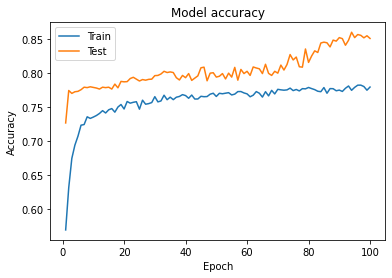

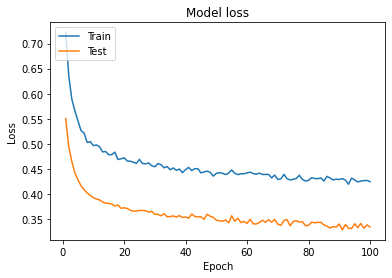

In [ ]:
plot_learningCurve(history, epochs)